In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dataset import cifar10
from vision import util


In [2]:
# Hyper-parameters
eval_iters = 200

Files already downloaded and verified
 frog   dog plane  frog  ship   cat   cat  deer truck  bird horse  frog   cat  ship  frog   cat   cat  ship   car   dog   dog   car   cat plane horse plane  deer plane   cat  frog horse   cat


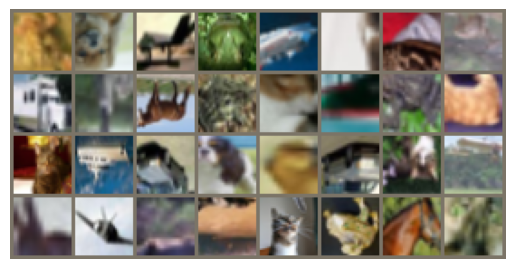

In [3]:
dataset = cifar10.CIFAR10DataSet()
downloader = dataset.train_dataloader()
images, labels = dataset.get_batch(downloader)
util.show_images(images, dataset.mean, dataset.std)
print(' '.join('%5s' % dataset.get_classes()[l] for l in labels))

In [4]:
# Let's take one image and build the initial patch building and positional embedding step.
images.shape

torch.Size([32, 3, 32, 32])

In [5]:
# Shape of images is batch (B), channel (C), height (H), width (W)
B, C, H, W = images.shape
B, C, H, W

(32, 3, 32, 32)

## Section 3.1
The standard transformer receives as input a $1D$ sequence of token embeddings. To handle $2D$ images, we reshape the image $x \in\mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $x_p \in\mathbb{R}^{N \cdot P^2 \cdot C}$, where $(H,W)$ is the resolution of the original image, and $C$ is the number of channels, $(P,P)$ is the resolution of each image patch, and $N = \frac{HW}{P^2}$

In [6]:
x_t = [torch.arange(0, 32) for _ in range(32)]
x = torch.stack(x_t, dim=-1)
kc, kh, kw = 2, 2, 2  # kernel size
dc, dh, dw = 2, 2, 2  # stride
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
print(patches.shape)

torch.Size([32, 4, 2, 2, 2])


In [7]:
# https://discuss.pytorch.org/t/patch-making-does-pytorch-have-anything-to-offer/33850/11
x = torch.randn(1, 500, 500, 500)  # batch, c, h, w
kc, kh, kw = 64, 64, 64  # kernel size
dc, dh, dw = 64, 64, 64  # stride
patches = x.unfold(1, kc, dc).unfold(2, kh, dh).unfold(3, kw, dw)
unfold_shape = patches.size()
patches = patches.contiguous().view(patches.size(0), -1, kc, kh, kw)
print(patches.shape)

# Reshape back
patches_orig = patches.view(unfold_shape)
output_c = unfold_shape[1] * unfold_shape[4]
output_h = unfold_shape[2] * unfold_shape[5]
output_w = unfold_shape[3] * unfold_shape[6]
patches_orig = patches_orig.permute(0, 1, 4, 2, 5, 3, 6).contiguous()
patches_orig = patches_orig.view(1, output_c, output_h, output_w)

# Check for equality
print((patches_orig == x[:, :output_c, :output_h, :output_w]).all())

torch.Size([1, 343, 64, 64, 64])
tensor(True)


In [8]:
class PatchEmbedding(nn.Module):
    """
    Patch embed layer that takes a 2D image to create embed patches of size P
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=96):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.patch_embd = nn.Conv2d(
            in_chans,
            embed_dim,
            kernel_size=patch_size, 
            stride=patch_size
            )
        
    def forward(self, x):
        print(f"x.shape: {x.shape}")
        x = self.patch_embd(x)
        print(f"patch_embd(x).shape: {x.shape}")
        x = x.flatten(2)
        print(f"flatten(patch_embed(x)).shape: {x.shape}")
        x = x.transpose(1,2)
        print(f"transpose(flatten(patch_embed(x)),(1,2)).shape: {x.shape}")
        return x

In [9]:
# data loading
def get_batch(dataset, split, batch_size=32):
    if split == 'train':
        downloader = dataset.train_dataloader(batch_size=batch_size)
    elif split == 'val':
        downloader = dataset.val_dataloader(batch_size=batch_size)
    elif split == 'test':
        downloader = dataset.test_dataloader(batch_size=batch_size)
    else:
        raise AttributeError(f'Invalid Split parameter ({split}) provided.')
    x, y_label = dataset.get_batch(downloader)
    y = F.one_hot(y_label, num_classes=len(dataset.get_classes()))
    return x,y

x, y = get_batch(dataset, "train")
print(x.shape, y.shape)

x_val, y_val = get_batch(dataset, "val")
print(x_val.shape, y_val.shape)

x_test, y_test= get_batch(dataset, "test")
print(x_test.shape, y_test.shape)


torch.Size([32, 3, 32, 32]) torch.Size([32, 10])
torch.Size([32, 3, 32, 32]) torch.Size([32, 10])
torch.Size([32, 3, 32, 32]) torch.Size([32, 10])


 bird   cat  deer   dog plane   car   cat   car truck plane horse horse  deer   cat  frog  deer  frog  deer plane   dog   car   cat  frog   dog  ship truck  deer  bird   cat truck horse horse


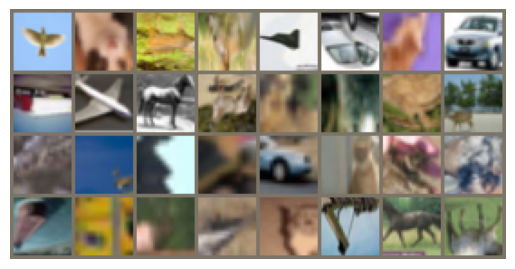

In [15]:
util.show_images(x, dataset.mean, dataset.std)
print(' '.join('%5s' % dataset.get_classes()[l] for l in torch.argmax(y, dim=-1)))

 deer truck horse  frog   dog  ship  deer   cat truck horse  deer   dog   cat  bird   cat  bird  ship  bird   cat  ship horse  ship  bird   dog  deer   dog  deer  bird   cat  frog  frog plane


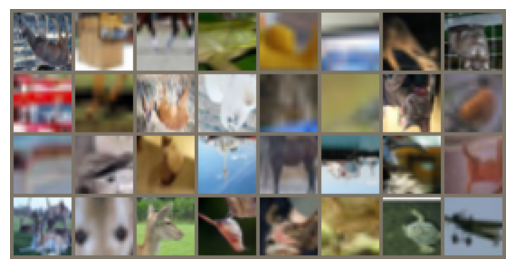

In [16]:

util.show_images(x_val, dataset.mean, dataset.std)
print(' '.join('%5s' % dataset.get_classes()[l] for l in torch.argmax(y_val, dim=-1)))


  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog


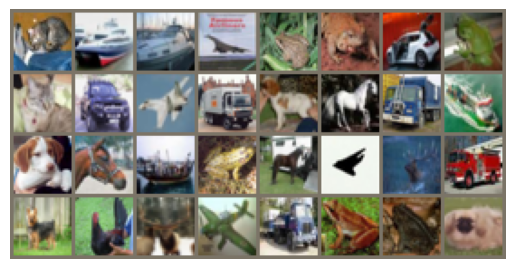

In [17]:
util.show_images(x_test, dataset.mean, dataset.std)
print(' '.join('%5s' % dataset.get_classes()[l] for l in torch.argmax(y_test, dim=-1)))


In [10]:
class VisionTransformerModel(nn.Module):

    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=96, depth=4, n_heads=6):
        super().__init__()
        self.patch_embedding_table = PatchEmbedding(img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        self.position_embedding_table = nn.Embedding(self.patch_embedding_table.n_patches, embedding_dim=embed_dim)

        # Every patch sequence begins with a CLS token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, idx, targets=None):
        print(idx.shape)
        patch_emb = self.patch_embedding_table(idx)
        pos_emb = self.position_embedding_table()
        


In [19]:
model = VisionTransformerModel()
model(x, y)

x.shape: torch.Size([32, 3, 32, 32])
patch_embd(x).shape: torch.Size([32, 96, 8, 8])
flatten(patch_embed(x)).shape: torch.Size([32, 96, 64])
transpose(flatten(patch_embed(x)),(1,2)).shape: torch.Size([32, 64, 96])


TypeError: Embedding.forward() missing 1 required positional argument: 'input'

In [12]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)